<a href="https://colab.research.google.com/github/BMCC-Muzician/BMCC-DS/blob/main/Rolling_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


### Time series

A time series is data that depends on time. A good examples for such data sets are  stock market values or price fluctuation. Let's look at a simple dataset that shows amount of passengers flying per month:

In [263]:
File_path="/content/sample_data/AirPassengers.csv"

data = pd.read_csv(File_path,parse_dates=True)  #index_col='Month', parse_dates=True
data["Month"] = pd.to_datetime(data["Month"],format='%Y-%m')
data.index = data["Month"]
data.head()

,Month,#Passengers
Month,,
1949-01-01,1949-01-01,112
1949-02-01,1949-02-01,118
1949-03-01,1949-03-01,132
1949-04-01,1949-04-01,129
1949-05-01,1949-05-01,121


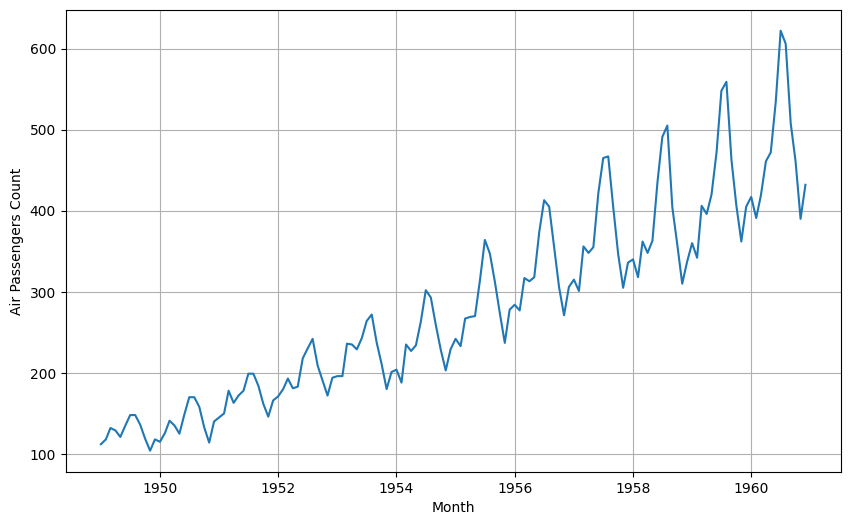

In [254]:
plt.figure(figsize=(10,6))
plt.xlabel("Month")
plt.ylabel("Air Passengers Count")
plt.plot(data['#Passengers'])
plt.grid()
plt.show()

While we can use linear regression directly on this data set (and we will do something similar at the end), this doesn't not give a good description of what is going on and doesnt not give good predictive power. In essence, this will give us general trend. However, it is possible to decompose this time series into 3 parts: general trend, seasonality (time depended fluctuations) and residues (the rest):

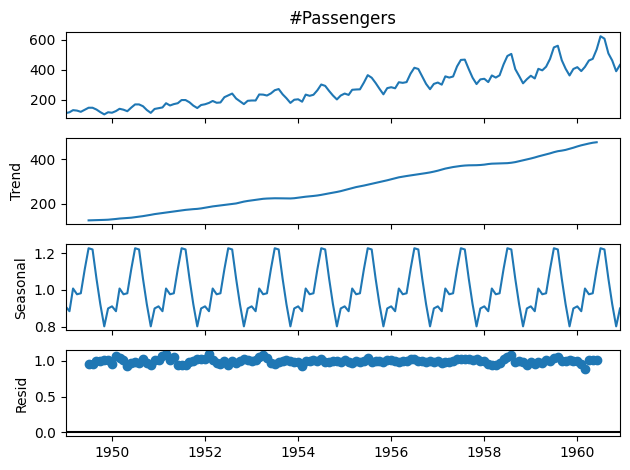

In [262]:
decom=seasonal_decompose(data.iloc[:,1],model='multiplicative')
decom.plot()
plt.show()

To get a better predictive power, common approach is to ask not how data depends on time, but how data depends on previous data. We can use "rolling window" technique:

In [256]:
X,y=[], []
lag=18
for i in range(len(data)-lag-1):
  X.append(data.iloc[i:i+lag,1])
  y.append(data.iloc[i+lag,1])

X[0], y[0]

(Month
 1949-01-01    112
 1949-02-01    118
 1949-03-01    132
 1949-04-01    129
 1949-05-01    121
 1949-06-01    135
 1949-07-01    148
 1949-08-01    148
 1949-09-01    136
 1949-10-01    119
 1949-11-01    104
 1949-12-01    118
 1950-01-01    115
 1950-02-01    126
 1950-03-01    141
 1950-04-01    135
 1950-05-01    125
 1950-06-01    149
 Name: #Passengers, dtype: int64,
 170)

In [257]:
X=np.squeeze(X)
y=np.squeeze(y)
X[0], y[0]

(array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
        126, 141, 135, 125, 149]),
 170)

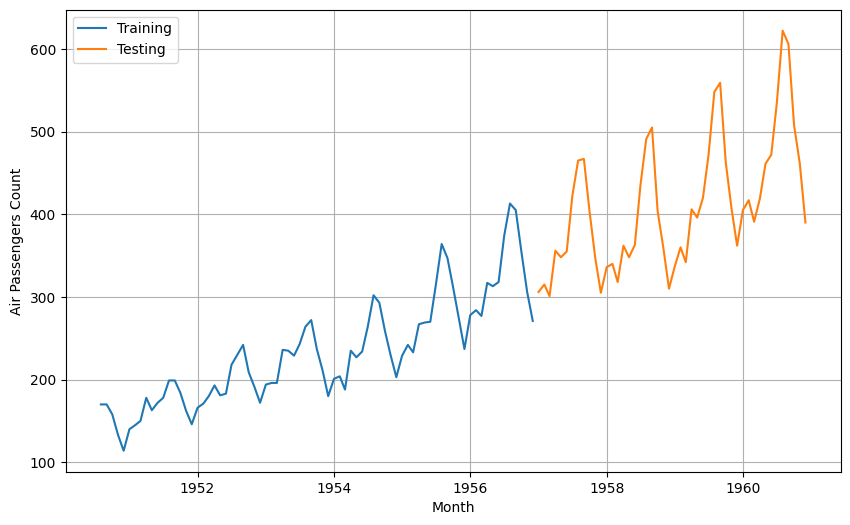

In [258]:
split_idx=48
x_train, y_train, x_test, y_test=X[:-split_idx], y[:-split_idx], X[-split_idx:], y[-split_idx:]

plt.figure(figsize=(10,6))
plt.xlabel("Month")
plt.ylabel("Air Passengers Count")

plt.plot(data['Month'][lag+1:-split_idx],y_train, label='Training')
plt.plot(data['Month'][-split_idx:],y_test, label='Testing')
plt.legend()
plt.grid()
plt.show()

Now let's use Linear Regression to predict the last two years. We have to be careful with our predictions and not use test set. For example, to get the first predicted value we can use the last 18 values on train set. To get the second value, we use last 17 values on train set plus our first predicted value; to get third value we use last 16 values of train set and first 2 predicted values and so on. Eventually, we will be using only predicted values:

In [230]:
regr = LinearRegression()
regr.fit(x_train, y_train)

LinearRegression()

In [231]:
predictingset=x_train[-1]
y_pred=[]
for i in range(len(x_test)):
  pred=regr.predict([predictingset])
  y_pred.append(pred[0])
  predictingset=np.append(predictingset, pred)
  predictingset=predictingset[1:]
y_pred

[268.4719239368023,
 310.54594490229437,
 323.012958461726,
 310.19831504241887,
 353.26180331217677,
 349.6919464102573,
 361.93350922542925,
 426.55425192088705,
 468.1667119137328,
 454.73456766192373,
 402.1738706337179,
 341.09102865551745,
 304.25904958227716,
 347.3441354614781,
 362.78130674676567,
 347.825552399141,
 390.29399014482686,
 391.5118627878077,
 408.7103428474601,
 486.1509788082709,
 527.8582920878225,
 510.38810001207077,
 452.26134906325717,
 380.1174895425043,
 342.08276726355945,
 387.85328902793606,
 404.66271230228244,
 387.9790227705695,
 429.7604645320897,
 436.1677665110515,
 460.6390954366539,
 551.3407179525675,
 594.1723257909358,
 570.8488302363535,
 506.63146855078344,
 422.29616715995627,
 382.82949751942283,
 431.65318693487234,
 449.03222147047114,
 430.39996745233566,
 471.7359481199376,
 483.95426498038785,
 518.0114650610016,
 623.0433082424588,
 667.4125267756575,
 636.9200312537978,
 565.3527526784267,
 468.12246459013727]

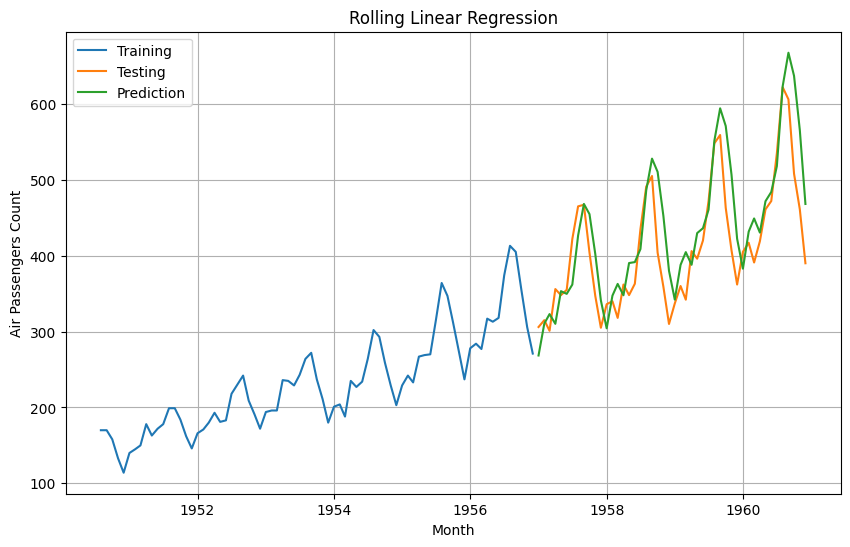

In [252]:
plt.figure(figsize=(10,6))
plt.xlabel("Month")
plt.ylabel("Air Passengers Count")

plt.plot(data['Month'][lag+1:-split_idx],y_train, label='Training')
plt.plot(data['Month'][-split_idx:],y_test, label='Testing')
plt.plot(data['Month'][-split_idx:],y_pred, label='Prediction')
plt.legend()
plt.title('Rolling Linear Regression')
plt.grid()
plt.show()


In [233]:
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Coefficient of determination: 0.59


### Other things.

Sometimes using some kind of smoothing is useful to remove outliers and improve forecasting. One of the easiest methods is rolling mean:

In [238]:
y_hat_sma = data.copy()
ma_window = 4
y_hat_sma['RollingMean'] = data['#Passengers'].rolling(ma_window).mean()
y_hat_sma.dropna(inplace=True)
y_hat_sma

,Month,#Passengers,RollingMean
Month,,,
1949-04-01,1949-04-01,129,122.75
1949-05-01,1949-05-01,121,125.00
1949-06-01,1949-06-01,135,129.25
1949-07-01,1949-07-01,148,133.25
1949-08-01,1949-08-01,148,138.00
...,...,...,...
1960-08-01,1960-08-01,606,558.75
1960-09-01,1960-09-01,508,567.75
1960-10-01,1960-10-01,461,549.25


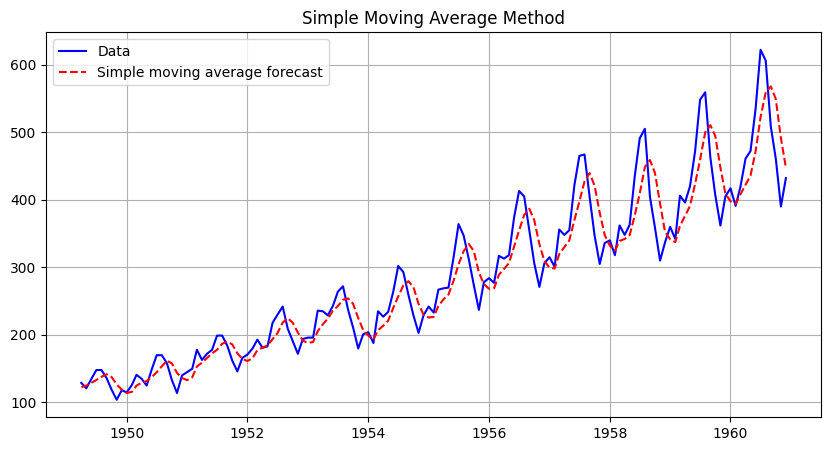

In [250]:
plt.figure(figsize=(10,5))

plt.plot(y_hat_sma['#Passengers'],label='Data',color='blue')
plt.plot(y_hat_sma['RollingMean'], label='Simple moving average forecast',linestyle='--', color='red')
plt.legend()
plt.title('Simple Moving Average Method')
plt.grid()
plt.show()

In [244]:
x=y_hat_sma.iloc[:,1]
y=y_hat_sma.iloc[:,2]


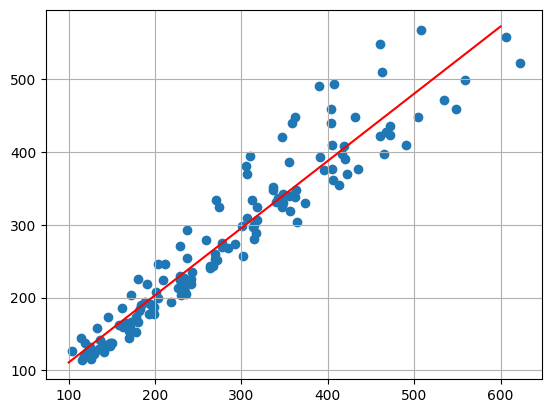

In [248]:
regr2 = LinearRegression()
regr2.fit(x.values.reshape(-1,1),y.values)


xv=np.linspace(100,600,1000).reshape(-1,1)
pred=regr2.predict(xv)
plt.scatter(x,y)
plt.plot(xv,pred, 'r')
plt.grid()
plt.show()

Some common algorithms used for time-series forecasting:

1. ARIMA: It stands for Autoregressive-Integrated-Moving Average. It utilizes the combination of Autoregressive and moving averages to predict future values. Read more about it here.
2. EWMA/Exponential Smoothening: Exponentially weighted moving average or Exponential Smoothening serves as an upgrade to the Moving averages. It works by reducing the lag effect shown by moving averages by putting on more weight on values that occurred more recently. Read more about it here.
3. Dynamic Regression Models: This algorithm also takes other miscellaneous information into account such as public holidays, changes in law, etc. Read more about it here.
4. Prophet: Prophet, which was released by Facebook’s Core Data Science team, is an open-source library developed by Facebook and designed for automatic forecasting of univariate time series data.
5. LSTM: Long Short-Term Memory (LSTM) is a type of recurrent neural network that can learn the order dependence between items in a sequence. It is often used to solve time series forecasting problems.